In [14]:
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable

from typing import Callable

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.lax as lax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jaxtyping import Array, Float  # https://github.com/google/jaxtyping
from jax import vmap
from functools import partial


jax.config.update("jax_enable_x64", True)


In [2]:
# Represents the interval [x0, x_final] discretised into n equally-spaced points.
class SpatialDiscretisation(eqx.Module):
    xmin: float = eqx.field(static=True)
    xmax: float = eqx.field(static=True)
    ymin: float = eqx.field(static=True)
    ymax: float = eqx.field(static=True)
    vals: Float[Array, "nx ny"]

    @classmethod
    def discretise_fn(cls, 
                      xmin: float, xmax: float, 
                      ymin: float, ymax:float,
                      nx: int, ny:int,
                      fn: Callable):
        """
        fn : must be a function with separated inputs f(x, y)
        """

        if nx < 2:
            raise ValueError("Must discretise [xmin, xmax] into at least two points")
        elif ny < 2:
            raise ValueError("Must discretise [ymin, ymax] into at least two points")

        # WARNING: meshgrid transposes by default, xv and yv are (ny, nx).
        # Set indexing="ij" for (nx, ny) shape
        xv, yv = jnp.meshgrid(jnp.linspace(xmin, xmax, nx),
                              jnp.linspace(ymin, ymax, ny),
                              indexing="ij"
                             )
        vals = vmap(fn)(jnp.vstack([xv.flatten(), yv.flatten()]).T).reshape(xv.shape)
        return cls(xmin, xmax, ymin, ymax, vals)

    @property
    def δx(self):
        return (self.xmax - self.xmin) / (self.vals.shape[0] - 1)
    
    @property
    def δy(self):
        return (self.ymax - self.ymin) / (self.vals.shape[1] - 1)


    def binop(self, other, fn):
        if isinstance(other, SpatialDiscretisation):
            if self.xmin != other.xmin or self.xmax != other.xmax:
                raise ValueError("Mismatched x-axis spatial discretisations")
            if self.ymin != other.ymin or self.ymax != other.ymax:
                raise ValueError("Mismatched y-axis spatial discretisations")
            other = other.vals
        return SpatialDiscretisation(self.xmin, self.xmax, self.ymin, self.ymax, fn(self.vals, other))

    def __add__(self, other):
        return self.binop(other, lambda x, y: x + y)

    def __mul__(self, other):
        return self.binop(other, lambda x, y: x * y)

    def __radd__(self, other):
        return self.binop(other, lambda x, y: y + x)

    def __rmul__(self, other):
        return self.binop(other, lambda x, y: y * x)

    def __sub__(self, other):
        return self.binop(other, lambda x, y: x - y)

    def __rsub__(self, other):
        return self.binop(other, lambda x, y: y - x)


def laplacian(y: SpatialDiscretisation) -> SpatialDiscretisation:

    # Pick one kernel for discrete laplacian
    # this works...
    # dx2, dy2 = 1, 1
    # .. and this does not
    dx2, dy2 = y.δx**2, y.δy**2 

    # Sol 1) Everything in 1 convolution : numerically instable if dx2 or dy2 !=1
    lap_kernel = jnp.array([[0, dy2, 0], [dx2, -2*(dx2 + dy2), dx2], [0, dy2, 0]])
    Δy = jax.scipy.signal.convolve(y.vals, lap_kernel, mode='same') / (dx2 * dy2)
    
    # Sol 2) try two convolution ? Also instable
#     lap_kernel_x = jnp.array([[0, 0, 0], [1, -2, 1], [0, 0, 0]]) # horizontal 2nd order diff
#     lap_kernel_y = lap_kernel_x.T # vertical 2nd order diff
#     Δy_x = jax.scipy.signal.convolve(y.vals, lap_kernel_x, mode='same') / dx2 
#     Δy_y = jax.scipy.signal.convolve(y.vals, lap_kernel_y, mode='same') / dy2
#     Δy = Δy_x + Δy_y

    
    # Explicit expression
#     x_next = jnp.roll(y.vals, shift=1, axis=0)
#     x_prev = jnp.roll(y.vals, shift=-1, axis=0)
#     y_next = jnp.roll(y.vals, shift=1, axis=1)
#     y_prev = jnp.roll(y.vals, shift=-1, axis=1)
#     Δy_x = (x_next - 2 * y.vals + x_prev) / (y.δx**2)
#     Δy_y = (y_next - 2 * y.vals + y_prev) / (y.δy**2)
#     Δy = Δy_x + Δy_y
    
    
    # Dirichlet boundary condition
#     Δy = Δy.at[0, :].set(0)
#     Δy = Δy.at[-1, :].set(0)
#     Δy = Δy.at[:, 0].set(0)
#     Δy = Δy.at[:, -1].set(0)
    
    # Neumann boundary condition
    Δy = Δy.at[0, :].set(Δy[1, :])
    Δy = Δy.at[-1, :].set(Δy[-2, :])
    Δy = Δy.at[:, 0].set(Δy[:, 1])
    Δy = Δy.at[:, -1].set(Δy[:, -2])

    return SpatialDiscretisation(y.xmin, y.xmax, y.ymin, y.ymax, Δy)




In [3]:
# test convolution with L4 or L8 on an image
# from scipy.datasets import face
# import jax.scipy as jsp

# fig, ax = plt.subplots(1, 3, figsize=(12, 5))

# # Load a sample image; compute mean() to convert from RGB to grayscale.
# image = jnp.array(face().mean(-1))
# ax[0].imshow(image, cmap='binary_r')
# ax[0].set_title('original')

# L4_kernel = jnp.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
# L8_kernel = jnp.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
# smooth_image_l4 = jsp.signal.convolve(image, L4_kernel, mode='same')
# smooth_image_l8 = jsp.signal.convolve(image, L8_kernel, mode='same')

# ax[1].imshow(smooth_image_l4, cmap ='binary_r')
# ax[1].set_title('L4 discrete laplacian')

# ax[2].imshow(smooth_image_l8, cmap ='binary_r')
# ax[2].set_title('L8 discrete laplacian')

# print(image.shape)
# print(smooth_image_l4.shape)
# print(smooth_image_l8.shape)

In [4]:
# ###############
# # Test vmap
# # over an image
# ##############

# import jax.numpy as jnp
# from jax import vmap
# def f(xy):
#     print(xy)
#     return xy.sum()

# x = jnp.linspace(0, 1, 10)
# y = jnp.linspace(1, 2, 5)
# xv, yv = jnp.meshgrid(x, y, indexing='ij')
# print("meshgrid() transposes to get an 'image' (ny, nx). Need to set indexing='ij' to get (nx, ny) shape.")
# print(xv.shape, yv.shape)
# vmap(f)(jnp.vstack([xv.flatten(), yv.flatten()]).T).reshape(xv.shape) 

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


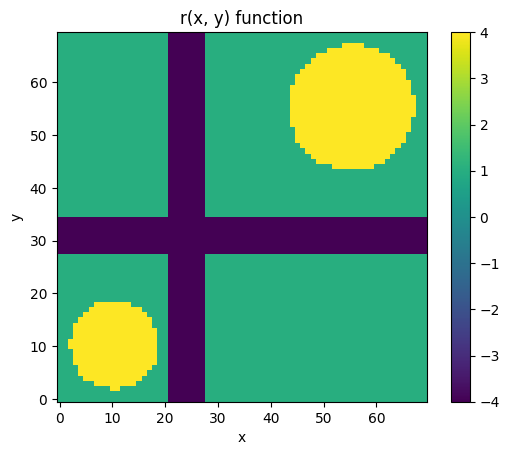

In [18]:
import numpy as np

# Spatial discretisation
xmin, xmax = 0, 1
ymin, ymax = 0, 1
nx, ny = 70, 70

# Function that defines the frontiers of Omega in terms of "r" values
def r_func(x, y, rs):
    """ TODO: modify for matching Soubeyrand's r_func()"""
    r1, r2, r3 = rs
    if x > 6 / 20 and x < 8 / 20:
        return r2
    if y > 8 / 20 and y < 10 / 20:
        return r2
    if (x - 0.15)**2 + (y - 0.15)**2 < 0.015:
        return r3
    if (x - 0.8)**2 + (y - 0.80)**2 < 0.03:
        return r3
    return r1


xv, yv = jnp.meshgrid(jnp.linspace(xmin, xmax, nx),
                      jnp.linspace(ymin, ymax, ny),
                      indexing="ij"
                     )
rs = np.array([1, -4, 4])
r_mat = np.vectorize(partial(r_func, rs=rs))(xv, yv)
r_mat = jnp.array(r_mat)
plt.imshow(r_mat.T, origin="lower")
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title("r(x, y) function")
print(r_mat) 

# set gamma
gamma = 1
D = 0.05


# initial condition
mu_init = jnp.array([0.70, 0.15])
def gauss_ic(xy):
    return jnp.exp(-jnp.linalg.norm(xy - mu_init))

y0 = SpatialDiscretisation.discretise_fn(xmin, xmax, ymin, ymax, nx, ny, gauss_ic)

# set vector field
def vector_field(t, y, args):
    return D * laplacian(y) + y * (r_mat - gamma * y)


# Prepare ODE object on discretized problem
term = diffrax.ODETerm(vector_field)


# Temporal discretisation
t0 = 0
t_final = 2
δt = 0.0001
saveat = diffrax.SaveAt(ts=jnp.linspace(t0, t_final, 30))

# Tolerances for non-stiff problems
# rtol = 1e-3
# atol = 1e-6
# Tolerances for stiff problems (along with using float64)
rtol = 1e-7
atol = 1e-9
stepsize_controller = diffrax.PIDController(
    pcoeff=0.3, icoeff=0.4, rtol=rtol, atol=atol, dtmax=0.001
)


In [166]:
a = jnp.array(0)
b = jnp.arange(3)
jnp.hstack([a,b])

Array([0, 0, 1, 2], dtype=int64)

In [6]:
solver = diffrax.Tsit5()
max_steps = int(1e6)
sol = diffrax.diffeqsolve(
    term,
    solver,
    t0,
    t_final,
    None, #δt,
    y0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps=max_steps,
)

sol.ys.vals.shape
sol.ts

Array([0.        , 0.06896552, 0.13793103, 0.20689655, 0.27586207,
       0.34482759, 0.4137931 , 0.48275862, 0.55172414, 0.62068966,
       0.68965517, 0.75862069, 0.82758621, 0.89655172, 0.96551724,
       1.03448276, 1.10344828, 1.17241379, 1.24137931, 1.31034483,
       1.37931034, 1.44827586, 1.51724138, 1.5862069 , 1.65517241,
       1.72413793, 1.79310345, 1.86206897, 1.93103448, 2.        ],      dtype=float64, weak_type=True)

In [23]:
sol.ys.vals.shape[1:3]

(70, 70)

[ 1  4  8 12 17 21 25 30]


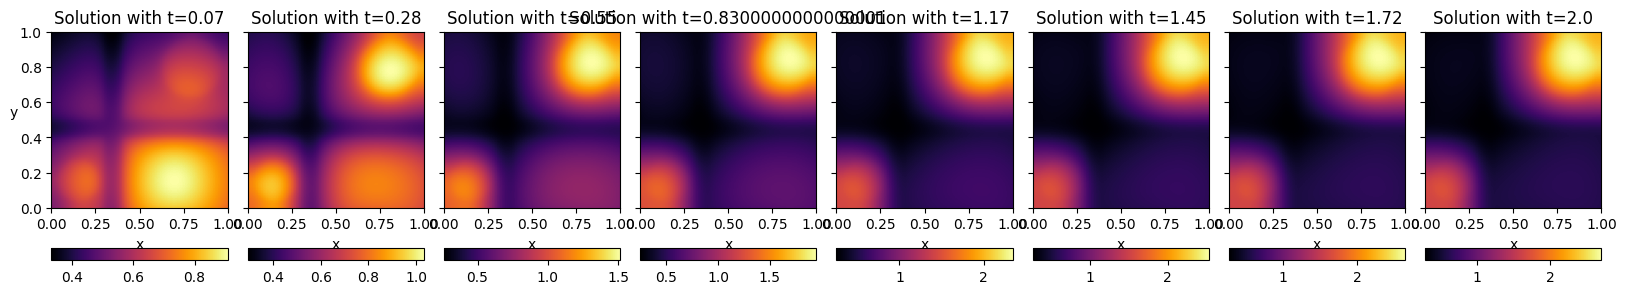

In [7]:
from mpl_toolkits.axes_grid1 import ImageGrid

nplot = 8
t_ind = jnp.floor(jnp.linspace(0, len(sol.ts), nplot)).astype(int)
t_ind = t_ind.at[0].set(1)
print(t_ind)

fig = plt.figure(figsize=(20, 20 * nplot))
grid = ImageGrid(
    fig,
    111,
    nrows_ncols=(1, nplot),
    axes_pad=0.2,
    share_all=True,
    cbar_location="bottom",
    cbar_mode="each",
    cbar_size="7%",
    cbar_pad=0.4,
)

for i, ax in enumerate(grid):
    ti = t_ind[i]
    im = ax.imshow(
        sol.ys.vals[ti, :, :].T, # plot last time stamp, /!\ transpose to have (ny, nx) shape
        origin="lower",
        extent=(xmin, xmax, ymin, ymax),
        aspect=(xmin - xmax) / (ymin - ymax),
        cmap="inferno",
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y", rotation=0)
    ax.set_title(f"Solution with t={sol.ts[ti].round(2)}")
    ax.cax.colorbar(im)
# plt.clim(0, 1)
plt.show()


# Reimplemeting MCMC sampler for reaction-diffusion in ecological model (Soubeyrand et. al.)


We re-implement "by-hand" the Metropolis-Hastings algorithm proposed by Soubeyrand et. al. The goal is to sample from the posterior of the statistical model with parameters $\theta = (D, \gamma, r_1, r_2, r_3, r_4)$ .For this we are provided with:

 * a prior $\pi(\theta) = \pi(D, \gamma, r_1, r_2, r_3, r_4) \propto \mathbf{1}(10^-2 \leq D \leq 1)\mathbf{1}(0.1 \leq \gamma \leq 10)\mathbf{1}(-10 \leq  r_1, r_2, r_3, r_4 \leq 10) $
 * a likelihood : $p(y \mid u, w,  t, \theta) = \mathcal{P}(y \mid \alpha \int_{w} u(t,x) dx )$, where $\alpha = $ is known and $u$ is a solution of reaction-diffusion with parameters $\theta$.


For a chain of length $N$, for $k=1, \ldots, N-1$ do

 * draw a proposal $\theta$ from $Q(\cdot \mid \theta^{(k)}$
 * draw $u \sim \mathcal{U}[0,1]$
 * $\delta := \min(1, ratio)$
 * accept $\theta^{(k+1)} = \theta$ is $\delta = u$

In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
from test_MH import vanilla_MH, log_prior, log_proposal, loglikelihood_func, sample_proposal, sample_model
import jax
import jax.numpy as jnp
import diffrax
from reaction_diffusion_solver import SpatialDiscretisation, diffrax_solver
import matplotlib.pyplot as plt

In [21]:
key = jax.random.PRNGKey(1)
n_iter = 100

Tmax = 2
times = (jnp.arange(0, 10) * 0.4 + 0.4) / Tmax
print(times)

omegas = [
    (jnp.array([0.1, 0.1]), 0.05),
    (jnp.array([0.5, 0.5]), 0.05),
    (jnp.array([0.2, 0.7]), 0.1),
]

# --- PDE solution for true parameters
r1 = 4.
r4 = -4.
r2 = 0.
r3 = 2.
true_params = {
    "D": jnp.array(0.05),
    "gamma": jnp.array(1.0),
    "rs": jnp.array([r1, r2, r3, r4]),
}

# Spatial discretisation
xmin, xmax = 0, 1
ymin, ymax = 0, 1
nx, ny = 70, 70

# init condition
mu_init = jnp.array([0.70, 0.15])

def gauss_ic(xy):
    return jnp.exp(-jnp.linalg.norm(xy - mu_init))

y0 = SpatialDiscretisation.discretise_fn(xmin, xmax, ymin, ymax, nx, ny, gauss_ic)

# Temporal discretisation
t0 = 0
δt = 0.0001

# Tolerances for non-stiff problems
rtol = 1e-3
atol = 1e-6
# Tolerances for stiff problems (along with using float64)
# rtol = 1e-7
# atol = 1e-9
stepsize_controller = diffrax.PIDController(
    pcoeff=0.3, icoeff=0.4, rtol=rtol, atol=atol, dtmax=0.001
)

solver = diffrax.Tsit5()
max_steps = int(1e6)
saveat = (times,)

pde_control = {
    "xboundary": (xmin, xmax),
    "yboundary": (ymin, ymax),
    "nx": nx,
    "ny": ny,
    "ode_hyperparams": {
        "t0": 0,
        "t1": int(times.max()),
        "dt0": 0.001,
        "y0": y0,
        "saveat": diffrax.SaveAt(ts=times),
        "stepsize_controller": stepsize_controller,
        "max_steps": max_steps,
        "solver": diffrax.Tsit5(),
    },
}

u_sol_true = diffrax_solver(true_params, pde_control)


# --- Statistical simulation according to true parameters
simu = sample_model(key, u_sol=u_sol_true, times=times, omegas=omegas)
simu["y"]
# --- Init MH algo
eq_params_init = {
    "D": jnp.array(0.07),
    "gamma": jnp.array(1.2),
    "rs": jnp.array([r1, r2, r3, r4]),
}

list_x = vanilla_MH(
    key,
    simu,
    log_prior,
    loglikelihood_func,
    sample_proposal,
    n_iter,
    eq_params_init,
    pde_control,
)


[0.2       0.4       0.6       0.8       1.        1.2       1.4000001
 1.6       1.8000001 2.       ]
0
{'D': array(0.06103004, dtype=float32), 'gamma': array(1.0609164, dtype=float32), 'rs': array([ 3.9555519 ,  0.02976068,  2.013807  , -4.1243734 ], dtype=float32)}
0.0
-43.549583435058594 0.0 -964.3597412109375
True 0.8635009527206421 1.0
1
{'D': array(0.0603913, dtype=float32), 'gamma': array(1.1219072, dtype=float32), 'rs': array([ 4.0648975 , -0.57051545,  2.3748066 , -3.8598797 ], dtype=float32)}
0.0
-42.98883819580078 0.0 -995.81396484375
False 0.47017180919647217 0.010866237804293633
2
{'D': array(0.06147569, dtype=float32), 'gamma': array(1.0839404, dtype=float32), 'rs': array([ 4.081474  ,  0.38276595,  1.6499894 , -4.0309873 ], dtype=float32)}
0.0
-42.98883819580078 0.0 -992.8860473632812
False 0.20508790016174316 0.05616190657019615
3
{'D': array(0.06105462, dtype=float32), 'gamma': array(0.99748576, dtype=float32), 'rs': array([ 3.9131672 , -0.25487098,  2.3059504 , -4.00

-115.39523315429688 0.0 -1183.8848876953125
False 0.46814239025115967 1.6425374838036078e-08
33
{'D': array(0.0318301, dtype=float32), 'gamma': array(0.27073392, dtype=float32), 'rs': array([ 3.367142 , -1.2583473,  3.1711183, -4.893625 ], dtype=float32)}
0.0
-115.39523315429688 0.0 -1184.599609375
True 0.9045588970184326 1.0
34
{'D': array(0.0322693, dtype=float32), 'gamma': array(0.28899822, dtype=float32), 'rs': array([ 3.3589923, -1.3461024,  3.2060552, -4.743939 ], dtype=float32)}
0.0
-185.04197692871094 0.0 -1189.2794189453125
False 0.4290057420730591 0.0003495079290587455
35
{'D': array(0.029955, dtype=float32), 'gamma': array(0.263705, dtype=float32), 'rs': array([ 2.9529788, -1.1691037,  3.2422187, -4.8487024], dtype=float32)}
0.0
-185.04197692871094 0.0 -1190.66552734375
True 0.3059256076812744 1.0
36
{'D': array(0.03006123, dtype=float32), 'gamma': array(0.27477875, dtype=float32), 'rs': array([ 3.1825507, -1.1173296,  3.1886253, -4.841245 ], dtype=float32)}
0.0
-207.9308013

-316.3818359375 -inf -1367.0562744140625
False 0.6834856271743774 0.0
66
{'D': array(0.01262559, dtype=float32), 'gamma': array(0.1024428, dtype=float32), 'rs': array([ 3.8842776, -1.1536943,  2.9923055, -6.2345   ], dtype=float32)}
0.0
-316.3818359375 0.0 -1367.7003173828125
True 0.4234510660171509 1.0
67
{'D': array(0.01211991, dtype=float32), 'gamma': array(0.09268361, dtype=float32), 'rs': array([ 3.4001098, -1.3394269,  3.1933448, -6.221806 ], dtype=float32)}
0.0
-468.235107421875 -inf -1379.4139404296875
False 0.9686406850814819 0.0
68
{'D': array(0.01507169, dtype=float32), 'gamma': array(0.10620227, dtype=float32), 'rs': array([ 3.907246 , -1.1339139,  2.721086 , -6.37956  ], dtype=float32)}
0.0
-468.235107421875 0.0 -1377.6397705078125
False 0.4714583158493042 4.4985548619536075e-10
69
{'D': array(0.01411874, dtype=float32), 'gamma': array(0.09922902, dtype=float32), 'rs': array([ 3.8411398, -1.08751  ,  3.0666628, -6.12891  ], dtype=float32)}
0.0
-468.235107421875 -inf -1376.

-669.7453002929688 -inf -1400.64599609375
False 0.8936811685562134 0.0


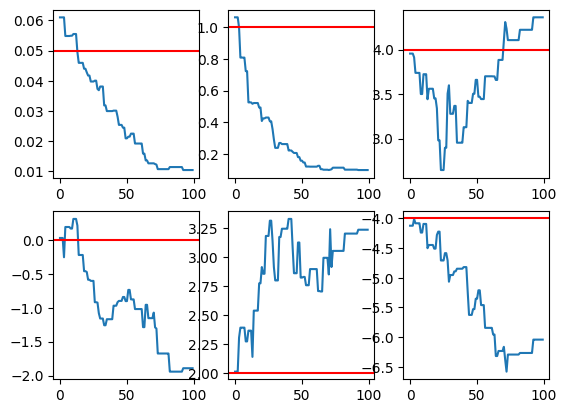

In [23]:
params_labels = ["D", "gamma", "rs"]
fig, axes = plt.subplots(2, 3)

for i in range(2):
    for j in range(3):
        idx = jnp.ravel_multi_index(jnp.array([i, j]), (2, 3))
        if idx < 2:
            axes[i, j].plot(list_x[:, idx])
            axes[i, j].axhline(y=true_params[params_labels[idx]], xmin=0, xmax=n_iter, c="r")
        else:
            axes[i, j].plot(list_x[:, idx])
            axes[i, j].axhline(y=true_params["rs"][idx - 2], xmin=0, xmax=n_iter, c="r")

plt.show()